# PRÉPAREZ DES DONNÉES POUR UN ORGANISME DE SANTÉ PUBLIQUE

![](Logo-Sante-Publique-France-.png)

# Table des matières

# Introduction

L'agence "Santé publique France" a lancé un **appel à projets pour rendre les données de santé plus accessibles**. L’agence souhaite faire explorer et visualiser des données, pour que ses agents puissent les exploiter.

Le jeu de données à analyser est issu de la plateforme **Open Food Facts**, qui est une association donnant accès à une base données de produits alimentaires :
- ouverte à tous
- où tout le monde peut contribuer

Dans le cadre de cet appel à projets, nous :
- proposerons une idée d'application
- mènerons à bien le nettoyage nécessaire à l'exploration des données
- explorerons les données traitées

# Partie 1 - Imports & Proposition d'application

## P1.1. Imports des librairies & du dataset

Commençons par importer les principales librairies dont nous aurons besoin :

In [1]:
import pandas as pd # to manipulate the dataset with dataframes
import numpy as np # for statistics and calculations
import matplotlib.pyplot as plt # for data visualisation
%matplotlib inline
import seaborn as sns # for data visualisation, with different proporties
import missingno as ms # for visualisation of missing data

## P1.2. Import du dataset

In [2]:
foodRaw=pd.read_csv('fr.openfoodfacts.org.products.csv', sep='\t',low_memory=False)

Nous pouvons regarder les dimensions du tableau généré :

In [3]:
print("Le tableau mis à disposition comporte ", foodRaw.shape[1], "variables et ", foodRaw.shape[0], "lignes / produits")

Le tableau mis à disposition comporte  162 variables et  320772 lignes / produits


Nous pouvons affihcer les premières lignes :

In [4]:
display(foodRaw.head())

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,0000000003087,http://world-fr.openfoodfacts.org/produit/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,NaN,1kg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000004530,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,14.0,14.0,NaN,NaN
2,0000000004559,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Peanuts,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
3,0000000016087,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055731,2017-03-09T10:35:31Z,1489055731,2017-03-09T10:35:31Z,Organic Salted Nut Mix,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,12.0,NaN,NaN
4,0000000016094,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055653,2017-03-09T10:34:13Z,1489055653,2017-03-09T10:34:13Z,Organic Polenta,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Nous avons à disposition 4 types de variables :
- Les informations générales sur la fiche du produit : nom, date de modification, etc.
- Un ensemble de tags : catégorie du produit, localisation, origine, etc.
- Les ingrédients composant les produits et leurs additifs éventuels.
- Des informations nutritionnelles : 
    - quantité en grammes d’un nutriment pour 100 grammes du produit.
    - des scores nutritionnels (comme le nutriscore)

## P1.3. Proposition d'application

Afin d'aider à améliorer la santé de nos concitoyens, nous pourrions utiliser les données mises à notre disposition pour aider les malades et les médecins.

En effet, un des principaux maux du 21$^{ème}$ est la multiplications de maladies chroniques dans nos sociétés industrialisées. Mes maladies cardiovasculaires représentent **la dépense la plus importante** pour l'Assurance Maladie.

**Hypertension, Diabètes, Cholestérol, Obésites, etc.** : Toutes ses pathologies sont, à des degrès différents, liées au régime alimentaire des malades.

En plus des médicaments, les médecins prescrivent également un **régime alimentaire adapté** aux pathologies chroniques des patients affectés.

Mais devant le nombre de produits disponibles en grandes surfaces, chacun avec une étiquette nutritionnelle qui lui est propre, le patient peut se retrouver démuni au moment de faire ses choix.

**MyHealthScore** : Une application **proposée par le médecin** à son patient pour l'aider à adapter son régime alimentaire à sa (ou ses) pathologie(s).

L'idée :
- le médecin configure le **profil** de son patient :
    - données biométriques : sexe, age, poids, taille, etc.
    - pathologie(s) : hypertension, diabètes, cholestérol, obésité, autre
    
    
- le profil permet de créé un score nutritionnel **adapté au patient** : *MyHealthScore*
    - ce score est basé sur les **mêmes données** nutritionnelles que le Nutri-Score :
        - La valeur énergétique (KJ)
        - Les lipides (g)
        - Les acides gras saturés (g)
        - Les sucres (g)
        - Les protéines (g)
        - Le sodium (mg)
        - Les fibres (g)
        - Fruits, légumes, etc. (%)
        
   mais **personnalisé** pour le profil du patient.


- l'**application** pourrait fonctionner ainsi :
    - le patient **scanne / rentre une référence** d'un produit
    - l'application **lui délivre ensuite son MyHeathScore personnalisé** selon les informations renseignées par son médecin.




## P1.4. Sélection des variables

Pour fonctionner, l'application ferait appel à la base de données d'OpenFoodFact pour récupérer les données nutritionnelles et calculer le MyHealthScore du patient.

Il faut pour cela que les données soient présentes. Regardons visuellement le niveau de remplissage du dataset. Pour cela nous allons utiliser la librairie `missingno` :

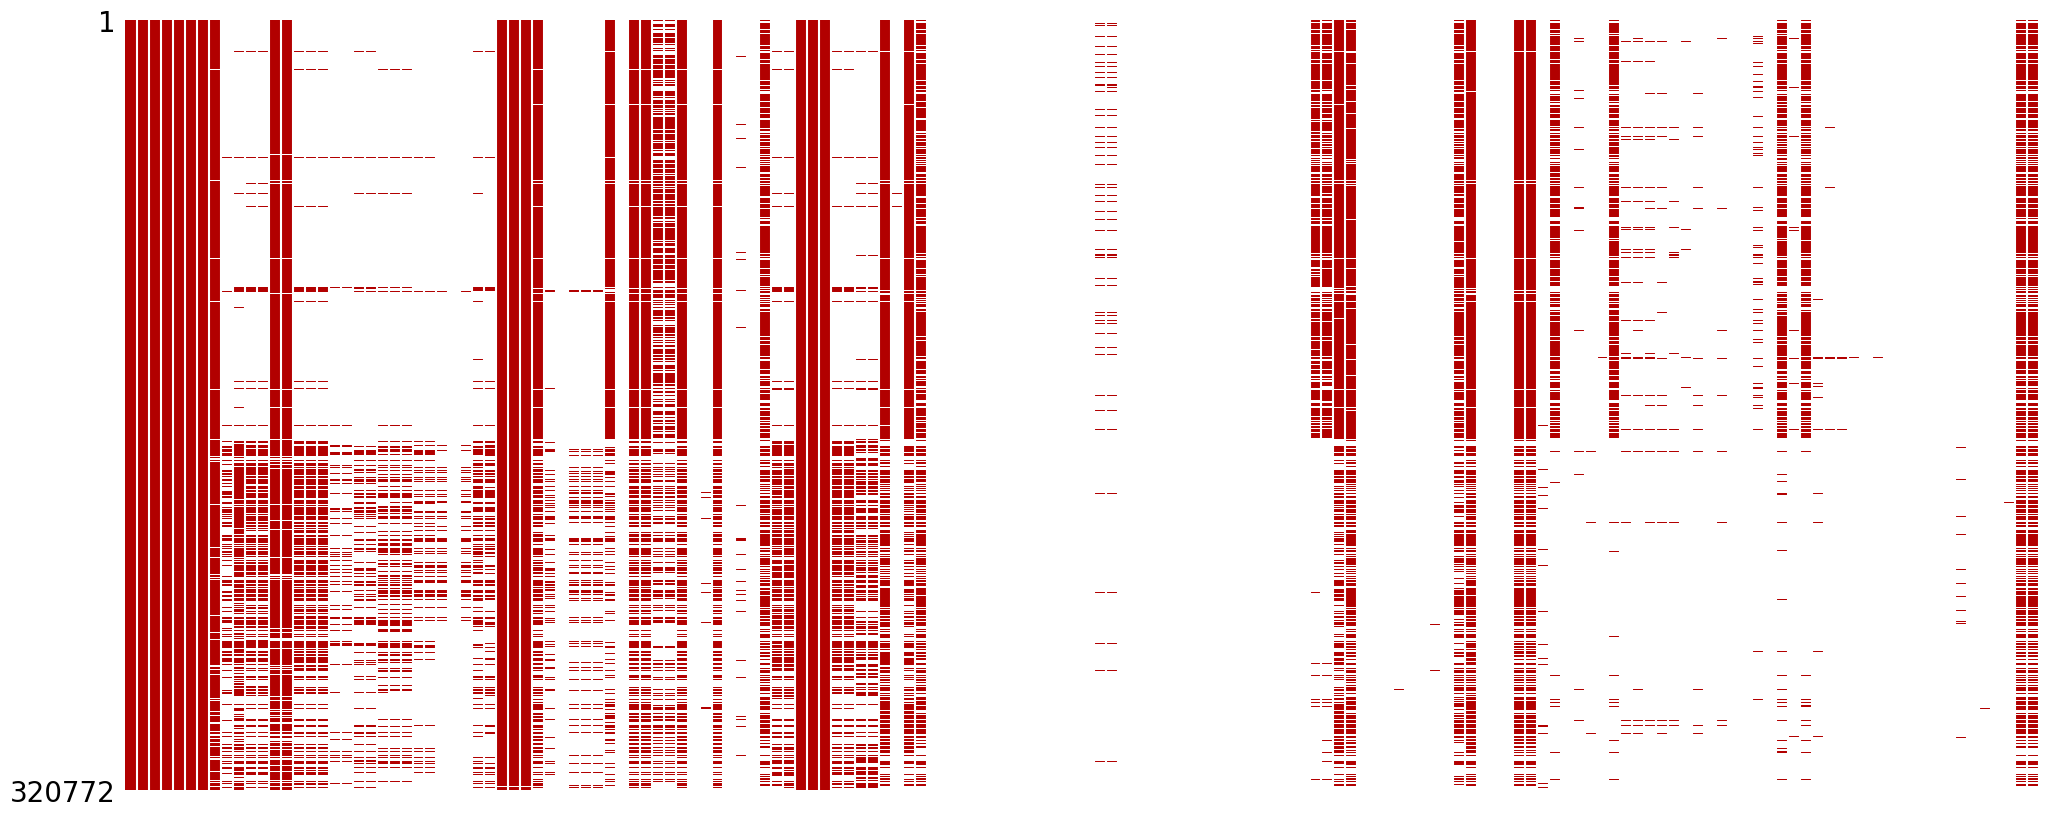

In [5]:
ms.matrix(foodRaw,color=[0.7,0.0,0.0],sparkline=False) # dataviz of missing data
plt.show()

Le data set est globalement **très peu renseigné**.

Nous pouvons regarder ce qu'il en est des features qui nous intéressent pour calculer, théoriquement, un MyHealthScore :

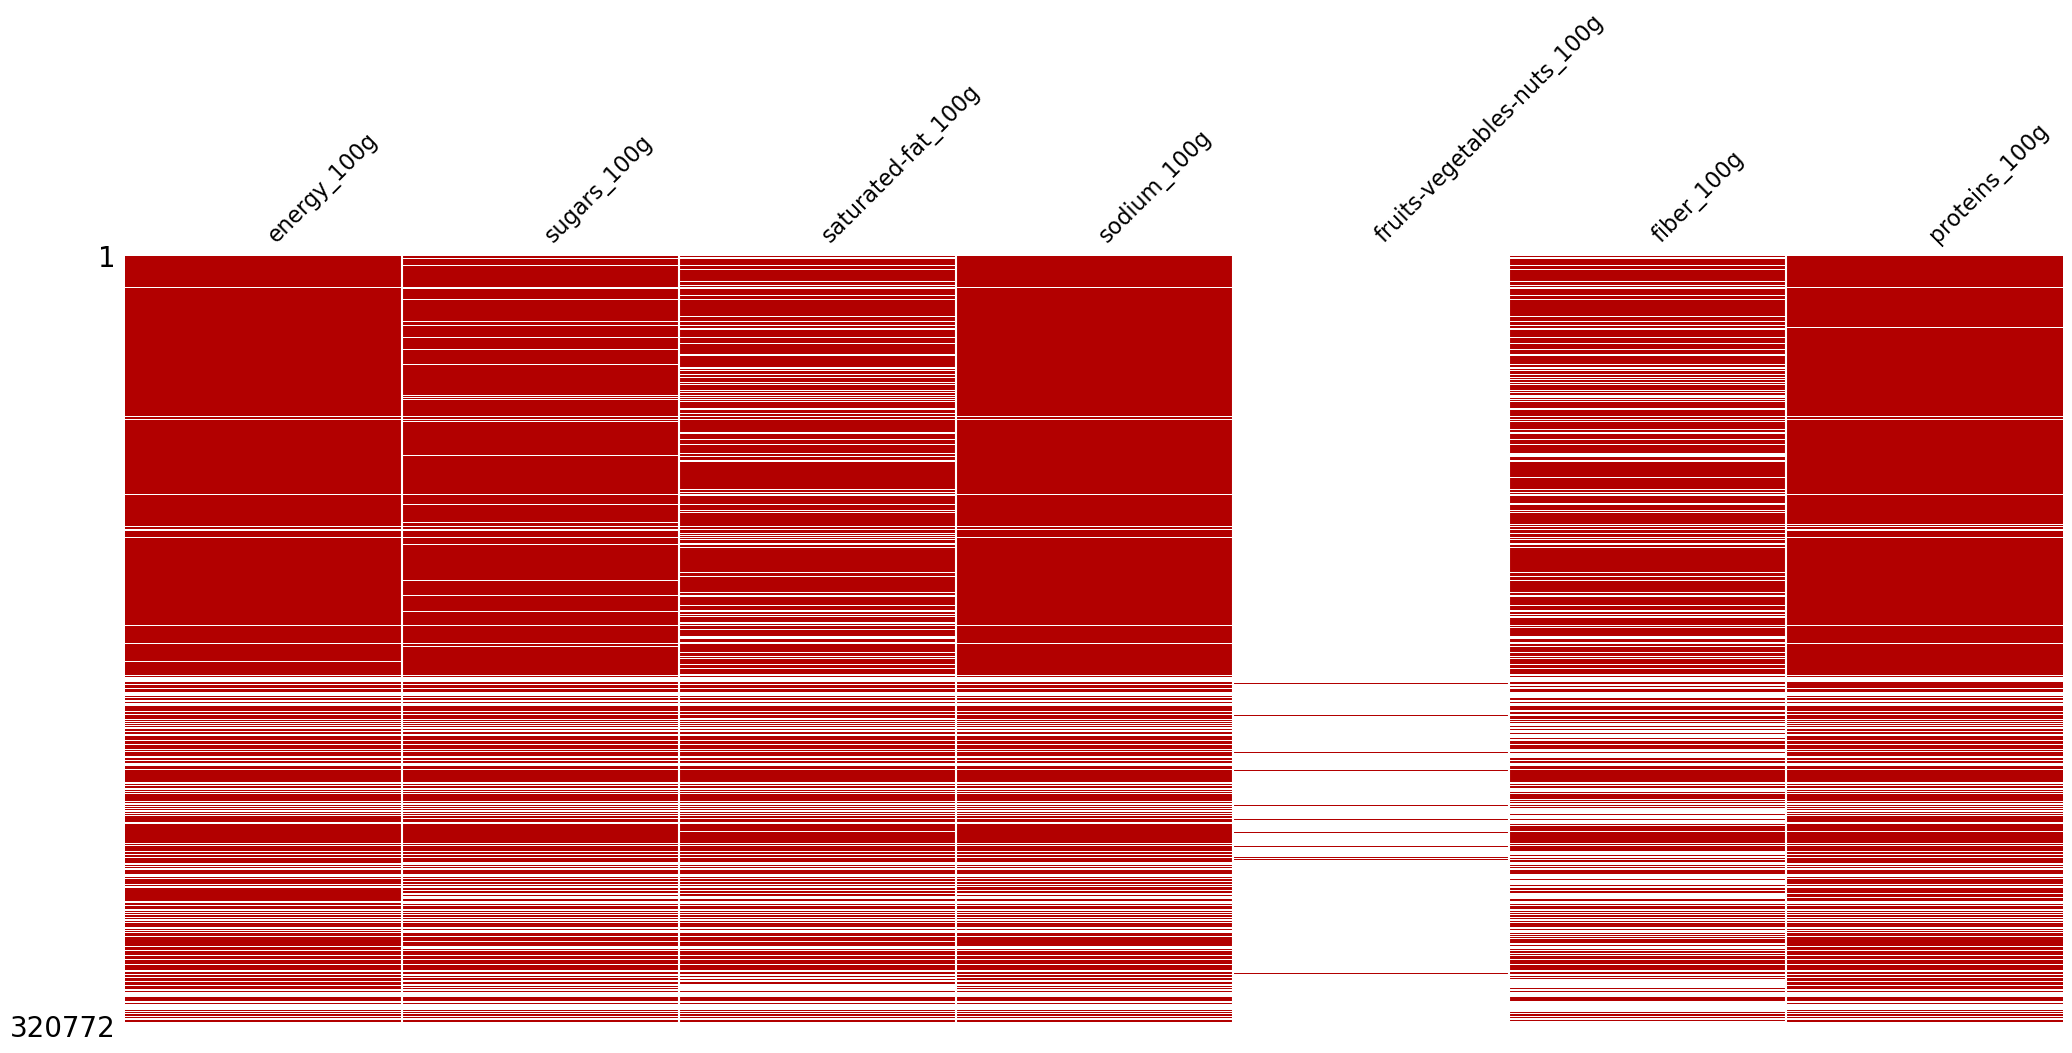

In [6]:
theoricalFeaturesNames=["energy_100g","sugars_100g","saturated-fat_100g","sodium_100g","fruits-vegetables-nuts_100g","fiber_100g","proteins_100g"]
ms.matrix(foodRaw[theoricalFeaturesNames],color=[0.7,0.0,0.0],sparkline=False) # dataviz of missing data
plt.show()

Malheureusement la feature concernant les **fruits et légumes** est **très peu renseignée**...

Or celle-ci se révelle indispensable pour calculer un MyHealthScore reflétant correctement les recommandations médicales.

Par exemple, si l'on regarde les **préconisations hygiéno-ditétiques pour les personnes atteinte d'hypertension**, le site internet de la **sécurité sociale indique** :
- sel : < 6g /j
- perdre du poids, soit via une IMC < 25 kg/m², soit en perdant 10% du poids initial
- activité physique, soit 30 min/j, soit 3x / semaine
- réduire consommation d'alcool
- augmenter la consommation de **fruits et légumes**
- réduire la consommation de graisses saturées
- arrêter le tabac

La construction d'un MyHealthScore devra donc passer par la prise en compte d'autres colonnes. Pour les déterminer, nous pourrons nous baser dans un premier sur le "taux de vide". Regardons ce que cela donne pour les colonnes `theoricalFeaturesNames` :

In [7]:
(foodRaw[theoricalFeaturesNames].isna().mean()*100).round(1).astype(str)+" %"

energy_100g                    18.6 %
sugars_100g                    23.6 %
saturated-fat_100g             28.4 %
sodium_100g                    20.4 %
fruits-vegetables-nuts_100g    99.1 %
fiber_100g                     37.4 %
proteins_100g                  19.0 %
dtype: object

Écrivons une fonction pour filtrer les colonnes en fonction de leur taux de valeurs manquantes :

In [8]:
def dropEmptyCols(df,emptinessThreshold=1) :
    
    """return an input pandas.DataFrame without its empty columns
    
    inputs
    ------
    df : pandas.DataFrame object
    
    optional inputs 
    ---------------
    emptinessThreshold : float, defaul : = 1. Gives the limit threshold of emptiness. 
    if >=threshold, column is dropped. 
    
    returns
    -------
    dfWithoutEmptyCols : pandas.DataFrame object, the same one without its empty columns
    
    """
    emptyColsNames=df.isna().mean().loc[df.isna().mean()>=emptinessThreshold].index
    dfWithoutEmptyCols = df.copy()
    dfWithoutEmptyCols = df.drop(columns=emptyColsNames)
    return dfWithoutEmptyCols

Nous avons d'ores et déjà fait une croix sur `fruits-vegetables-nuts_100g`. Basons-nous sur le taux de `fiber_100g` :

In [9]:
foodWithout_38=dropEmptyCols(foodRaw,emptinessThreshold=0.38)

In [10]:
(foodWithout_38.isna().mean().sort_values()*100).round(2).astype(str)+" %"

last_modified_t                              0.0 %
last_modified_datetime                       0.0 %
creator                                      0.0 %
created_t                                    0.0 %
created_datetime                             0.0 %
code                                        0.01 %
url                                         0.01 %
states_tags                                 0.01 %
states                                      0.01 %
states_fr                                   0.01 %
countries_fr                                0.09 %
countries_tags                              0.09 %
countries                                   0.09 %
product_name                                5.54 %
brands                                      8.86 %
brands_tags                                 8.86 %
energy_100g                                 18.6 %
proteins_100g                              18.97 %
salt_100g                                  20.35 %
sodium_100g                    

N'ayant pas à notre disposition la teneur en fruits et légumes, nous pouvons nous baser sur le Nutri-Score, qui prend en compte celle-ci dans son calcul.

A partir du Nutri-Score, il sera possible dans le cadre du développement de l'application, de créer un MyHealthScore en adaptant les pondérations des autres valeurs nutritionnelles.

On peut donc sélectionner les variables suivantes pour notre analyse :
- `code`, `product_name` et `brands` pour identitifer les produits
- `nutrition-score-fr_100g` qui correspond au socre nutritionnel
- `nutrition_grade_fr` qui correspond au Nutri-Score, l'échelle graphique scindant le score nutritionnel en 5 classes A, B, C, D et E
- `energy_100g`
- `proteins_100g`
- `fiber_100g`
- `sodium_100g` et `salt_100g`, qui sont liées et dont l'analyse commune pourrait servir dans le traitement
- `sugars_100g` et `carbohydrates_100g`
- `saturated-fat_100g` et `fat_100g`
- `countries_fr`, qui liste les pays de dans lesquels le produit est commercialisé. Nous souhaitons réaliser l'étude pour la France dans un premier temps. Cette colonne servira essentiellement à filtrer.

In [15]:
workFeatures=theoricalFeaturesNames+["code",
                                     "product_name",
                                     "brands",
                                     "nutrition-score-fr_100g",
                                     "nutrition_grade_fr",
                                     "salt_100g",
                                     "carbohydrates_100g",
                                     "fat_100g",
                                     "countries_fr"]

In [17]:
foodRawLight = foodRaw.copy()
foodRawLight = foodRawLight[workFeatures]
foodRawLight.head()

,energy_100g,sugars_100g,saturated-fat_100g,sodium_100g,fruits-vegetables-nuts_100g,fiber_100g,proteins_100g,code,product_name,brands,nutrition-score-fr_100g,nutrition_grade_fr,salt_100g,carbohydrates_100g,fat_100g,countries_fr
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0000000003087,Farine de blé noir,Ferme t'y R'nao,NaN,NaN,NaN,NaN,NaN,France
1,2243.0,14.29,28.57,0.000,NaN,3.6,3.57,0000000004530,Banana Chips Sweetened (Whole),NaN,14.0,d,0.00000,64.29,28.57,États-Unis
2,1941.0,17.86,0.00,0.250,NaN,7.1,17.86,0000000004559,Peanuts,Torn & Glasser,0.0,b,0.63500,60.71,17.86,États-Unis
3,2540.0,3.57,5.36,0.482,NaN,7.1,17.86,0000000016087,Organic Salted Nut Mix,Grizzlies,12.0,d,1.22428,17.86,57.14,États-Unis
4,1552.0,NaN,NaN,NaN,NaN,5.7,8.57,0000000016094,Organic Polenta,Bob's Red Mill,NaN,NaN,NaN,77.14,1.43,États-Unis


# Partie 2 - Nettoyage

## P2.1. Centrer l'étude sur la France

Comme expliqué plus haut, nous allons nous concentrer sur le France dans le cadre cette étude.

Regardons tout d'abord

In [18]:
foodRawLightFr=foodRawLight.copy()
foodRawLightFr.countries_fr

0             France
1         États-Unis
2         États-Unis
3         États-Unis
4         États-Unis
             ...    
320767      Roumanie
320768    États-Unis
320769         Chine
320770        France
320771    États-Unis
Name: countries_fr, Length: 320772, dtype: object

# Partie 3 - Exploration

# Tests 

In [ ]:
testNutri=foodWithout_38[["nutrition_grade_fr","nutrition-score-fr_100g"]]
testNutri=testNutri.loc[(testNutri["nutrition_grade_fr"].notna())&(testNutri["nutrition-score-fr_100g"].notna())]
testNutri=testNutri.sort_values("nutrition_grade_fr")

In [ ]:
sns.boxplot(data=testNutri,x="nutrition_grade_fr",y="nutrition-score-fr_100g")

In [ ]:
testEnerNut=foodWithout_38[["nutrition_grade_fr","energy_100g"]]

In [ ]:
testEnerNut=testEnerNut.loc[(testEnerNut["nutrition_grade_fr"].notna())&(testEnerNut["energy_100g"].notna())]
testEnerNut=testEnerNut.loc[testEnerNut["energy_100g"]<3700]
testEnerNut=testEnerNut.sort_values("nutrition_grade_fr")

In [ ]:
sns.boxplot(data=testEnerNut,x="nutrition_grade_fr",y="energy_100g")

In [ ]:
foodRaw.pnns_groups_2.value_counts()